## AOS 575, Problem Set 4

Note to self: try upwind before piecewise linear method! If you can't get 2D advection working, try 1D first!

### Imports

In [82]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd # Only used for data statistics during debugging

In [178]:
%config InlineBackend.figure_format = 'svg'

### Problem 1

#### Definitions

Function for $u$ (horizontal component of velocity)

In [3]:
def u_x(x, y, t):
    ''' Define horizontal component of velocity. '''
    return (np.sin(np.pi*x)**2)*np.sin(2*np.pi*y)*np.cos(np.pi*t/5)

Function for $v$ (vertical component of velocity)

In [4]:
def u_y(x, y, t):
    ''' Define vertical component of velocity. '''
    return -np.sin(2*np.pi*x)*(np.sin(np.pi*y)**2)*np.cos(np.pi*t/5)

Function to select $r$ value at each grid point

In [5]:
def r_sel(c, v, print_bool=False):
    ''' Decide r value to use at each grid point given a constant and variable array. '''
    
    # Lengths in the horizontal (x) and vertical (y) directions
    l_x, l_y = c.shape[0], c.shape[1]
    # Initialize array for r
    r = np.full(shape=(l_x, l_y), fill_value=np.nan)
    # Iterate over each grid point
    for i in range(0, l_x):
        for j in range(0, l_y):
            # Print values
            print('x: {0:4d} | y: {1:4d} | C: {2:5.2f}, V:{3:5.2f}'.format(i, j, c[i, j], v[i, j])) if print_bool else None
            # Select lesser of both values
            r[i, j] = np.nanmin([c[i, j], v[i, j]])

    return r

Function to define plot parameters

In [19]:
def plot(x, y, u, v, phi, times, t=0):
    
    # Select timesteps of interest
    u, v, phi = u[:, :, t], v[:, :, t], phi[:, :, t]
    
    ''' Quiver plot (q) for velocity & tracer field. '''
    fig, ax = plt.subplots(figsize=(4, 4))
    q = ax.quiver(x, y, u, v)   
    P = ax.contour(x, y, phi, levels=12)
    
    # Format colorbar
    cax = fig.add_axes([ax.get_position().x1 + 0.01,
                        ax.get_position().y0,
                        0.03,
                        ax.get_position().height])
    colorbar = fig.colorbar(P, cax=cax)
    
    # Figure formatting
    ax.set_title('Time: {0:.2f} s'.format(times[t]))
    ax.set_aspect('equal')

#### Implentation of numerical methods

__Spatial, first-order upwind advection__: Define a first-order upwind advection scheme to test basic functionality.

In [157]:
def fou_s(u, v, phi, dx):
    ''' First-order upwind advection scheme in space. '''
    
    # Assume equal grid spacing in x- and y-axes
    dy = dx
    
    # Initialize array holding differential values of u, v, and phi
    # Default value of 0 chosen to indicate no gradient
    d_u = np.full(shape=u.shape, fill_value=0, dtype=float)
    d_v = np.full(shape=v.shape, fill_value=0, dtype=float)
    d_phi_x = np.full(shape=phi.shape, fill_value=0, dtype=float)
    d_phi_y = np.full(shape=phi.shape, fill_value=0, dtype=float)
    
    # Index through all grid points (except for boundaries)
    # Assume u, v, and phi all have equivalent dimensions
    # Note: i corresponds to row (y-axis) and j corresponds to column (x-axis)
    for i in range(1, u.shape[0]):
        for j in range(1, u.shape[1]):
            # Print grid point and field values
            if print_bool:
                print('u[{0:2d}, {1:2d}]: {2:5.2f} | v[{0:2d}, {1:2d}]: {3:5.2f} | phi[{0:2d}, {1:2d}]: {4:5.2f}'.format(i, j, u[i, j], v[i, j], phi[i, j]))
             # Calculate differences
            d_u[i, j] = u[i, j] - u[i, j-1]
            d_v[i, j] = v[i, j] - v[i-1, j]
            d_phi_x[i, j] = phi[i, j] - phi[i, j-1]
            d_phi_y[i, j] = phi[i, j] - phi[i-1, j]
            
            # if print_bool:
            #     print('d_u[{0:2d}, {1:2d}]: {2:7.4f} | d_v[{0:2d}, {1:2d}]: {3:7.4f} | d_phi_x[{0:2d}, {1:2d}]: {4:7.4f}'.format(i, j, d_u[i, j], d_v[i, j], d_phi_x[i, j]))

    # Calculate field differential for use in the temporal scheme
    d_field = (1/dx)*(d_u*phi + d_phi_x*u) + (1/dy)*(d_v*phi + d_phi_y*v)
    
    return d_field

__Temporal, first-order upwind advection__: Define a first-order upwind advection scheme to test basic functionality.

In [164]:
def fou_t(u, v, phi, i, t, dt, dx):
    ''' First-order upwind advection scheme in time. '''
    
    # Define tracer concentrations for next timestep
    phi[:, :, i] = phi[:, :, i-1] - dt*fou_s(u[:, :, i-1], v[:, :, i-1], phi[:, :, i-1], dx)
    
    return phi

#### Model initialization
Initialize parameters for the model, grid, and data structures.

In [188]:
''' Define model parameters. '''

cfl = 0.5 # Courant number
dt = 0.05 # PLACEHOLDER VALUE
t_max = 5 # Maximum time
times = np.arange(0, t_max, dt) # Define time array

''' Define grid parameters. '''

x_min, x_max = [0, 1] # Horizontal domain limits
y_min, y_max = [0, 1] # Vertical domain limits
dx = 0.02 # Horizontal grid spacing
dy = 0.02 # Vertical grid spacing

# Generate horizonal and vertical grid points
gp_x = np.arange(x_min, x_max, dx) 
gp_y = np.arange(y_min, y_max, dy) 
X, Y = np.meshgrid(gp_x, gp_y)


''' Initialize velocity field and tracer concentration arrays. '''

# Initiate 3-dimensional arrays dictated by (x, y, t)
u = np.full(shape=(len(gp_x), len(gp_y), len(times)), fill_value=np.nan)
v = np.full(shape=(len(gp_x), len(gp_y), len(times)), fill_value=np.nan)
phi = np.full(shape=(len(gp_x), len(gp_y), len(times)), fill_value=np.nan)

# Initialize tracer concentrations
r_const = np.full(shape=(len(gp_x), len(gp_y)), fill_value=1) # Constant argument for r
r_var = 4*np.sqrt((X-1/4)**2 + (Y-1/4)**2) # Variable argument for r
r = r_sel(r_const, r_var, print_bool=print_bool)

In [166]:
# Switch to turn printing on or off for debugging
print_bool = False

#### Run the numerical scheme

In [189]:
# Define artificial loop step limit for debugging
loop_max = 10

for i, t in enumerate(times):
    # Cut at initial timestep for now
    if i > loop_max:
        break
        
    # Print variables for each time step
    print('Time step: {0:4d} | Time: {1:4.2f} s'.format(i, t)) if print_bool else None
    
    # Assign velocity field and tracer concentration for the given timestep
    u[:, :, i] = u_x(X, Y, t)
    v[:, :, i] = u_y(X, Y, t)
    if i == 0:
        phi[:, :, i] = (1/2)*(1 + np.cos(np.pi*r)) 
    else:
        phi = fou_t(u, v, phi, i, t, dt, dx)

#### Visualization

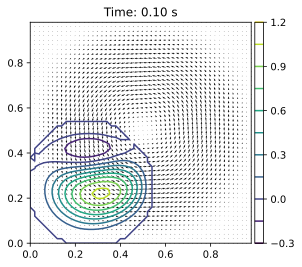

In [198]:
plot(X, Y, u, v, phi, times, t=2)